## Лабораторная работа №1 (курс "Математические методы анализа текстов")

#### Тема: Определение частей речи и выделение именованных сущностей.


**Выдана**:   25 февраля 2017

**Дедлайн**:   <font color='red'>9:00 утра 13 марта 2017</font>

**Среда выполнения**: Jupyter Notebook (Python 2.7)

#### Правила:

Результат выполнения задания - отчет в формате Jupyter Notebook с кодом и выводами. В ходе выполнения задания требуется реализовать все необходимые алгоритмы, провести эксперименты и ответить на поставленные вопросы. Дополнительные выводы приветствуются. Чем меньше кода и больше комментариев - тем лучше.

Все ячейки должны быть "выполненными", при этом результат должен воспроизвдиться при проверке (на Python 2.7). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Совсем.


Задание выполняется самостоятельно. Вы можете обсуждать идеи, объяснять друг другу материал, но не можете обмениваться частями своего кода. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов, а также предвзято негативное отношение семинаристов в будущем. Если вы нашли в Интернете какой-то код, который собираетесь заимствовать, обязательно укажите это в задании: вполне вероятно, что вы не единственный, кто найдёт и использует эту информацию.

#### Постановка задачи:

В данной лабораторной работе вам предстоит:

- обучить скрытую марковскую модель на размеченных данных и реализовать алгоритм Витерби для задачи POS-теггинга (определение частей речи слов в тексте)

- научиться использовать ряд POS-теггеров из библиотеки NLTK и сравнить качество их работы

- придумать различные признаки для CRF и использовать их в реализации CRF из пакета CRFsuite для решения задачи NER (выделение именованных сущностей в тексте)

- использовать готовое решение для решения задачи NER и сравнить качество

#### Комментарии и советы:

1. Для выполнения потребуются модули Python numpy, nltk, pycrfsuite (для импорта последнего нужно установить пакет python-crfsuite).

2. Все необходимые для выполнения задания данные либо приложены, либо могут быть скачаны с помощью nltk.download().

3. Посмотреть параметры конструктора и других методов классов можно набрав и выполнив в ячейке с кодом '?full_method_name'.

4. В коде Stanford NER tagger, возможно, присутствует ошибка. Для её устранения в файле /usr/local/lib/python2.7/site-packages/nltk/tag/api.py (или его аналоге в Windows) замените строку с номером 66 на следующую: tagged_sents = self.tag_sents([untag(sent) for sent in gold])

### 1. Определение частей речи (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM). Формула совместной плотности наблюдаемых и скрытых переменных задается как

$$ p(X, T) = p(T) p(X|T) = p(t_1)  \prod_{i=2}^N p(t_i|t_{i-1}) \prod_{i=1}^N p(x_i|t_i)$$

В данном случае:

- наблюдаемые переменные $X$ - это слова корпуса;

- скрытые переменные $T$ - это POS-теги.

#### 1.1. Обучение HMM на размеченных данных

Требуется построить скрытую марковскую модель и настроить все ее параметры с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(t_i | t_{i - 1})$ посчитайте на основе частот биграмм POS-тегов.

- Вероятности эмиссий наблюдаемых состояний $p(x_i | t_i)$ посчитайте на основе частот "POS-тег - слово".

- Обратите внимание на проблему разреженности счетчиков и сделаейте все вероятности сглаженными по Лапласу (add-one smoothing).

- Распределение вероятностей начальных состояний $p(t_1)$ задайте равномерным.

Обратите внимание, что так как мы используем размеченные данные, то у нас нет необходимости в оценивании апостериорных вероятностей на скрытые переменные с помощью алгоритма forward-backword и использовании EM-алгоритма.

In [1]:
#сделать класс

In [1]:
# your code here
import nltk

In [2]:
from collections import Counter
from itertools import chain
import numpy as np

In [3]:
class My_HMM:
    '''Потрясающий класс, оценивающий вероятности.'''
    def __init__(self, tagged_sents):
        self.un_tags = set(t[1] for t in chain(*tagged_sents))
        self.tag_dict = {t:i for (i,t) in enumerate(self.un_tags)}
        
        tags_pair = []
        for sent in tagged_sents:
            tags = [t[1] for t in sent]
            tags_pair.extend(list(zip(tags[:-1], tags[1:])))
        self.tags_transition = Counter(list(chain(tags_pair)))
        self.transitions_freq = np.zeros((len(self.un_tags), len(self.un_tags)))
        for t1, t2 in self.tags_transition:
            self.transitions_freq[self.tag_dict[t1], self.tag_dict[t2]] = self.tags_transition[(t1, t2)]
        
        self.transitions_freq += 0.01
        self.transitions_freq /= sum(self.tags_transition.values()) + 0.01*len(self.un_tags)
            
        self.emissions = Counter(list(chain(*tagged_sents)))
        self.un_words = set(t[0] for t in chain(*tagged_sents))
        self.word_dict = {t:i for (i,t) in enumerate(self.un_words)}
        self.emissions_freq = np.zeros((len(self.un_words), len(self.un_tags)))
        for w, t in self.emissions:
            self.emissions_freq[self.word_dict[w], self.tag_dict[t]] = self.emissions[(w, t)]
        
        self.emissions_freq += 0.01
        self.emissions_freq /= sum(self.emissions.values()) + 0.01*len(self.un_words)
    
    def get_emissions_freq(self, word_index, tag_index=None):
        if word_index is None and tag_index is None:
            return (np.zeros(len(self.un_tags)) + 0.01) / (sum(self.tags_transition.values()) + 0.01*len(self.un_tags))
        elif tag_index is None:
            return self.emissions_freq[word_index]
        else:
            return self.emissions_freq[:, tag_index]

Загрузите brown корпус с универсальной системой тегирования. Для этого вам понадобятся ресурсы brown и universal_tagset из nltk.download().  В этой системе содержатся следующие теги:

- ADJ - adjective (new, good, high, ...)
- ADP - adposition	(on, of, at, ...)
- ADV - adverb	(really, already, still, ...)
- CONJ	- conjunction	(and, or, but, ...)
- DET - determiner, article	(the, a, some, ...)
- NOUN	- noun	(year, home, costs, ...)
- NUM - numeral	(twenty-four, fourth, 1991, ...)
- PRT -	particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- .	- punctuation marks	(. , ;)
- X	- other	(ersatz, esprit, dunno, ...)

Обратите внимание, что тегсеты в корпусах текстов и в различных теггерах могут быть разными. Проверять это можно, глядя на сами теги, а симптом - подозрительно низкое качество теггирования. В таких случаях рекомендуется всё приводить сперва к универсальному тегсету, а потом уже мерять качество. Полезной может оказаться эта ссылка http://www.nltk.org/_modules/nltk/tag/mapping.html

Проанализируйте данные, с которыми Вы работаете. В частности, ответьте на вопросы:
- Каков общий объем датасета, формат?
- Приведены ли слова к нижнему регистру? Чем  это нам может в дальнейшем помешать?
- Как распределены слова в корпусе?  Как распределены теги в корпусе? Подсчитайте частоты и отобразите любым удобным для Вас способом. Проинтерпретируйте полученные результаты.

Задем сделайте случайное разбиение выборки на обучение и контроль в отношении 9:1 и обучите скрытую марковскую модель из предыдущего пункта. Если впоследствии обучение моделей будет занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

In [4]:
from nltk.corpus import brown
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

brown_tagged_sents = brown.tagged_sents(tagset="universal")
print(brown_tagged_sents[0], '\n')
print(brown_tagged_sents[1])

([(u'The', u'DET'), (u'Fulton', u'NOUN'), (u'County', u'NOUN'), (u'Grand', u'ADJ'), (u'Jury', u'NOUN'), (u'said', u'VERB'), (u'Friday', u'NOUN'), (u'an', u'DET'), (u'investigation', u'NOUN'), (u'of', u'ADP'), (u"Atlanta's", u'NOUN'), (u'recent', u'ADJ'), (u'primary', u'NOUN'), (u'election', u'NOUN'), (u'produced', u'VERB'), (u'``', u'.'), (u'no', u'DET'), (u'evidence', u'NOUN'), (u"''", u'.'), (u'that', u'ADP'), (u'any', u'DET'), (u'irregularities', u'NOUN'), (u'took', u'VERB'), (u'place', u'NOUN'), (u'.', u'.')], '\n')
[(u'The', u'DET'), (u'jury', u'NOUN'), (u'further', u'ADV'), (u'said', u'VERB'), (u'in', u'ADP'), (u'term-end', u'NOUN'), (u'presentments', u'NOUN'), (u'that', u'ADP'), (u'the', u'DET'), (u'City', u'NOUN'), (u'Executive', u'ADJ'), (u'Committee', u'NOUN'), (u',', u'.'), (u'which', u'DET'), (u'had', u'VERB'), (u'over-all', u'ADJ'), (u'charge', u'NOUN'), (u'of', u'ADP'), (u'the', u'DET'), (u'election', u'NOUN'), (u',', u'.'), (u'``', u'.'), (u'deserves', u'VERB'), (u'the',

Корпус хранит данные в формате list(list(tuple(str, str))). Слова внутри не приведены к нижнему регистру, поэтому, например, "the" и "The" - это разные слова. В то же время, часть речи не зависит от величины букв, поэтому, скорее всего, приведение к нижнему регистру даст более точный результат, однако для чистоты эксперимента не будем этим заниматься.

In [100]:
words_count = Counter(w[0] for w in chain(*brown_tagged_sents))

In [101]:
words_count.most_common(1)

[(u'the', 62713)]

In [102]:
un_words = set(t[0] for t in chain(*brown_tagged_sents))

In [103]:
word_dict = {t:i for (i,t) in enumerate(un_words)}

In [104]:
empiric = np.array([62713.0/i for i in range(1, len(words_count)+1, 1)])

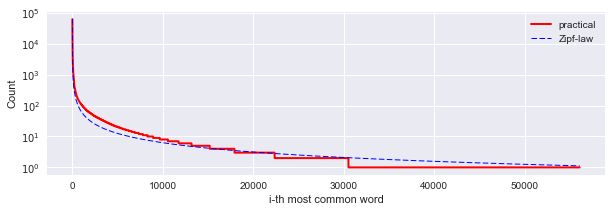

In [105]:
plt.figure(figsize=(10, 3))
plt.plot([n[1] for n in words_count.most_common()], 'r', linewidth=2, label='practical')
plt.plot(empiric, 'b--', linewidth=1, label='Zipf-law')
plt.ylabel('Count')
plt.xlabel('i-th most common word')
plt.yscale('log')
plt.legend()

Если расположить слова в порядке от самого частотного к самому низкочастотному, то видим, что распределение слов похоже на закон Ципфа. Закон подвергается критике, но им до сих пор пользуются при СЕО-оптимизации, так как считают, что естественные текст удовлетворяет этому закону (в отличии от сильно "тошнотных").

In [108]:
sent_lens = Counter(np.array([len(sent) for sent in brown_tagged_sents]))
sent_lens = np.array(list(sent_lens.values()))

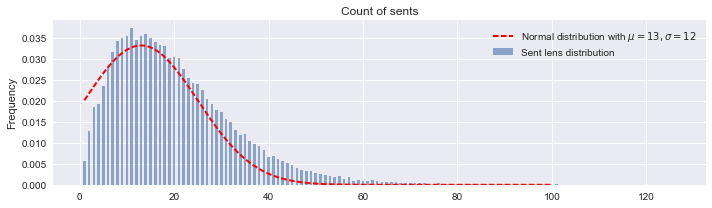

In [111]:
ind = np.arange(len(sent_lens)) + 1
plt.figure(figsize=(10, 3))
width = 0.55
plt.bar(ind, sent_lens/float(sent_lens.sum()), width, alpha=0.6, label='Sent lens distribution')

x = np.arange(1, 100, 0.05)
y = 1/np.sqrt(2*144*np.pi) * np.exp(-(x-13)**2/(2*144))
plt.plot(x, y, 'r--', linewidth=2, label='Normal distribution with $\\mu=13, \\sigma=12$')

plt.ylabel('Frequency')
plt.title('Count of sents')
plt.legend()
plt.tight_layout()

Число слов в предложении похоже на нормальное распределение с некоторыми говорками. В принципе, здесь сложно было ожидать что-то другое: предложение имеет какую-то среднюю длину и редко бывает очень коротким или длинным. 

In [112]:
tags_count = Counter(t[1] for t in chain(*brown_tagged_sents))

In [113]:
tags_count_most_common = tags_count.most_common()

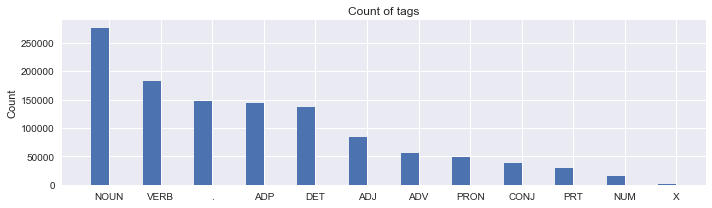

In [114]:
ind = np.arange(12)
plt.figure(figsize=(10, 3))
width = 0.35
plt.bar(ind, [t[1] for t in tags_count_most_common], width)
plt.ylabel('Count')
plt.title('Count of tags')
plt.xticks(ind + width/2, [t[0] for t in tags_count_most_common])
plt.tight_layout()

Среди тегов самыми употребимыми являются глаголы и существительные, что тоже неудивительно - эти части речи основа повествования.

In [115]:
from sklearn.model_selection import train_test_split

In [117]:
brown_tagged_train, brown_tagged_test = train_test_split(brown_tagged_sents, test_size=0.1, random_state=666)

#### 1.2 Алгоритм Витерби для применения модели

Чтобы использовать обученную модель для определения частей речи на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{T} = \arg \max_{T} p(T|X) = \arg \max_{T} p(X, T) $$

Определим функцию, определяющую максимальную вероятность последовательности, заканчивающейся на $i$-ой позиции в состоянии $k$:

$$\delta(k, i) = \max_{t_1, \dots t_{i-1}} p(x_1, \dots x_i, t_1, \dots t_i=k)$$

Тогда $\max_{k} \delta(k, N)$ - максимальная вероятность всей последовательности. А состояния, на которых эта вероятность достигается - ответ задачи.

Алгоритм Витерби заключается в последовательном пересчете функции $\delta(k, i)$ по формуле:

$$\delta(k, i) = \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$

Аналогично пересчитывается функция, определяющая, на каком состоянии этот максимум достигается:

$$s(k, i) = \arg \max_{m} \delta(m, i-1) p(t_i = k|t_{i-1} = m) p(x_i|t_i=k) $$


На практике это означает заполнение двумерных массивов размерности: (длина последовательности) $\times$ (количество возможных состояний). Когда массивы заполнены, $\arg \max_{k} \delta(k, N)$ говорит о последнем состоянии. Начиная с него можно восстановить все состояния по массиву $s$. 

Осталось уточнить, как стартовать последовательный пересчет (чем заполнить первый столбец массива вероятностей):

$$\delta(k, 1) = p(k) p(x_1|t_1=k)$$

В реализации рекомендуется перейти к логарифмам, т.к. произведение большого числа маленьких вероятностей может приводить к вычислительным ошибкам.

In [118]:
%%time
my_hmm = My_HMM(brown_tagged_train)

Wall time: 2.46 s


In [119]:
def viterbi_algorithm(test_tokens_list):
    m = np.zeros((len(my_hmm.un_tags), len(test_tokens_list)))
    token = test_tokens_list[0]
    m[:, 0] = -np.log(1.0/len(my_hmm.un_tags)) - np.log(my_hmm.get_emissions_freq(my_hmm.word_dict.get(token)))
    
    for i,token in enumerate(test_tokens_list[1:]):
        emissions = -np.log(my_hmm.get_emissions_freq(my_hmm.word_dict.get(token)).copy())
        for k in range(len(my_hmm.un_tags)):
            emissions[k] += np.min(-np.log((m[:, i])) - np.log(my_hmm.transitions_freq[:, k]))
        m[:, i+1] = emissions
        
    inverse_tag_dict = {v:k for (k,v) in my_hmm.tag_dict.items()}
    return [(token, inverse_tag_dict[np.argmin(m[:, i])]) for i,token in enumerate(test_tokens_list)]

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'he can stay'
- 'a milk can'
- 'i saw a dog'
- 'an old saw'

In [120]:
viterbi_algorithm(u'he can stay'.split())

[(u'he', u'PRON'), (u'can', u'VERB'), (u'stay', u'VERB')]

In [121]:
viterbi_algorithm('a milk can'.split())

[('a', u'DET'), ('milk', u'NOUN'), ('can', u'VERB')]

In [122]:
viterbi_algorithm('i saw a dog'.split())

[('i', u'NOUN'), ('saw', u'VERB'), ('a', u'DET'), ('dog', u'NOUN')]

In [123]:
viterbi_algorithm('an old saw'.split())

[('an', u'DET'), ('old', u'ADJ'), ('saw', u'VERB')]

Модельные примеры с достоинством прошли испытание. Единственная ошибка в предложении 'i saw a dog': I - это местоимение, а не существительное. 

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [124]:
%%time
# your code here
errors = 0.0
for sent in brown_tagged_test:
    tokens = [t[0] for t in sent]
    tags = [t[1] for t in sent]
    vit = viterbi_algorithm(tokens)
    errors += sum([v!=s for v,s in zip(vit,sent)])
print(1.0 - errors / len(list(chain(*brown_tagged_test))))

0.930009612414
Wall time: 9.74 s


93% полностью без аугментаций данных и дополнительных моделей - очень достойный результат для наивной реализации скрытой марковской цепи. 
Скорее всего такой положительный результат обеспечен еще и структурной простотой английского языка, для которого HMM действительно удачная модель в силу детерминированности порядка тегов в предложении (есть мнение, что в немецком это тоже будет работать, так как там предложения тоже имеют предельно определенную структуру).

#### 1.3. Готовые POS-теггеры из NLTK

В прошлом пункте Вы реализовали свой POS-тегер на основе скрытой марковской модели. Теперь сравните его работу с готовыми средставми, доступными в библиотеке NLTK: http://www.nltk.org/api/nltk.tag.html

Примерный набор кандидатов для сравнения:
- Простейший теггер, который всем словам ставит в соответствие одну и ту же метку
- Основанный на правилах RegexpTagger (правила можно поискать в Интернете или придумать самим)
- N-граммные теггеры (разберитесь и поэкспериментируйте с параметром backoff)
- Теггеры на основе графических моделей (можно взять только Stanford): 
    - HiddenMarkovModelTagger
    - CRFTagger
    - StanfordPOSTagger (потребуется .jar файл теггера и обученная модель (легко находятся в Интернете), чтобы подать на вход конструктору класса)
- BrillTagger, основанный на трансформациях

Если работа с какими-то модулями приводит к техническим проблемам, которые Вы не можете решить, это не страшно, модуль можно пропустить. Однако навык быстрого освоения документации / поиска моделей в гугле полезен.  Чем более полным и корректным будет сравнение, тем лучше.

При проведении экспериментов обращайте внимание на следующие моменты (и отразите их в отчете):
- Какой подход лежит в основе теггера
- На каких данных он обучен (если Вы скачали готовую модель)
- Сколько времени занимает обучение на brown корпусе (если обучаете сами)
- Какая точность получается на контролькой выборке (метод evaluate())

Сформируйте рекоммендиции о том, какую технологию Вы бы использовали, если встретитесь с задачей определения частей речи в будущем.

In [33]:
import nltk
from nltk.tag import DefaultTagger
from nltk.tag import RegexpTagger
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger
from nltk.tag import TrigramTagger
from nltk.tag.stanford import StanfordPOSTagger
# your code here

#### DefaultTagger

In [34]:
%%time
tagger_default = DefaultTagger('NOUN')

Wall time: 0 ns


In [35]:
tagger_default.evaluate(gold=brown_tagged_test)

0.23615443084423243

Фантастический теггер, который просто всем словам ставит одну метку. Очевидно, что нужно взять просто самую высокочастотную - существительное - и не ожидать впечатляющих результатов. Обучения тут в принципе нет, точность 23,6%, но может колебаться от жанра к жанру. Этот теггер подойдет только для заглушки в метод backoff для других теггеров.

#### RegexpTagger

Простой теггер, который по правилам, задающимися при помощи регулярных выражений, ставит в соответствие тег. От количества и качества выбранных правил зависит качествою

In [304]:
regexp_tagger = RegexpTagger(
    [(r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), 
    (r'(The|the|A|a|An|an)$', 'DET'), 
    (r'.*able$', 'ADJ'), 
    (r'.*ness$', 'ADJ'), 
    (r'.*ly$', 'ADV'), 
    (r'(.|,|!|\?|:|;)$', '.'),
    (r'(on|of|at|On|Of|At)$', 'ADP'),
    (r'(Already|already|still|Still)$', 'ADV'),
    (r'(And|and|Or|or|But|but)$', 'CONJ'), 
    (r'.*ing$', 'VERB'), 
    (r'.*ed$', 'VERB'), 
    (r'.*', 'NOUN')])

In [303]:
regexp_tagger.evaluate(gold=brown_tagged_test)

0.5641456967283464

Ожидаемо имеет невысокое качество. Обучения как такового нет, а вот правила подбирать надо вручную. Кроме того, нельзя учитывать взаимодействие тегов (по крайней мере напрямую). Вывод - подходит только для совсем примитивных сценариев, когда нет никакой возможности брать другие теггеры. Гораздо проще скачать готовый StanfordPOSTagger с гораздо более высокой точности и без необходимости кропотливого составления правил.

#### NgramTagger

In [127]:
%%time
tagger_uni = UnigramTagger(brown_tagged_train)

Wall time: 2.11 s


In [128]:
tagger_uni.evaluate(gold=brown_tagged_test)

0.9320694153592639

In [129]:
%%time
tagger_bi = BigramTagger(brown_tagged_train, backoff=tagger_uni)

Wall time: 4.67 s


In [130]:
tagger_bi.evaluate(gold=brown_tagged_test)

0.9405661025095265

In [131]:
%%time
tagger_tri = TrigramTagger(brown_tagged_train, backoff=tagger_bi)

Wall time: 5.9 s


In [132]:
tagger_tri.evaluate(gold=brown_tagged_test)

0.940085481822239

Обратимся к нетленной Википедии: An n-gram model is a type of probabilistic language model for predicting the next item in such a sequence in the form of a $(n-1)$–order Markov model. Backoff - теггер, к которому обращается целевой, если сам не может определить часть речи. С первого вгляда кажется, что с увеличением $n$ в $n$-граммах точность должна расти, но это не так. Более того, без последовательной передачи предыдущей $n-1$-граммной модели точность сильно падает. 

В остальном же метод показывает достаточно высокую точность, быстро обучается.

#### BrillTagger
Вновь обратимся к бессмертной классике:

The Brill tagger is an inductive method for part-of-speech tagging. It was described and invented by Eric Brill in his 1995 PhD thesis. It can be summarized as an "error-driven transformation-based tagger". It is

1) a form of supervised learning, which aims to minimize error

2) transformation-based in the sense that a tag is assigned to each word and changed using a set of predefined rules. Note: If the word is known, it first assigns the most frequent tag, or if the word is unknown, it naively assigns the tag "noun" to it. Applying over and over these rules, changing the incorrect tags, a quite high accuracy is achieved. This approach ensures that valuable information such as morphosyntact construct of words are employed in an automatic tagging process.

In [133]:
from nltk.tag.brill_trainer import BrillTaggerTrainer
from nltk.tag.brill import fntbl37, Template

In [134]:
%%time
Template._cleartemplates()
templates = fntbl37()
tagger_init = tagger_bi
tagger_brill = BrillTaggerTrainer(tagger_init, templates, trace=0)
tagger_brill = tagger_brill.train(brown_tagged_train[:10000], max_rules=50)

Wall time: 49.3 s


In [135]:
tagger_brill.evaluate(gold=brown_tagged_test)

0.9533025507226476

nltk предлагает большой набор уже готовых шаблонов, возьмем самый крупный - fntbl37. На Python 2 теггер учится в 3 раза дольше, чем на 3 версии, причем на всем корпусе обучить модель не удалось. В качестве стартовой модели была взята самая удачная модель до этого основанная на биграммах. В целом очень удачный теггер, даже на небольшой подвыборке можно увеличить качество распознавания других теггеров.

#### Теггеры на основе графических моделей

In [136]:
from nltk.tag.hmm import HiddenMarkovModelTrainer

In [137]:
%%time
trainer = HiddenMarkovModelTrainer()
tagger_markov = trainer.train_supervised(brown_tagged_train)

Wall time: 1.6 s


In [138]:
tagger_markov.evaluate(gold=brown_tagged_test)

0.7647275910604552

Совершим магию преобразования к универсальному тагсету для теггера из Стэнфорда.

In [139]:
from collections import defaultdict
from os.path import join
from nltk.data import load

_UNIVERSAL_DATA = "taggers/universal_tagset"
_UNIVERSAL_TAGS = ('VERB','NOUN','PRON','ADJ','ADV','ADP','CONJ','DET','NUM','PRT','X','.')
_MAPPINGS = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 'UNK')))


def _load_universal_map(fileid):
    contents = load(join(_UNIVERSAL_DATA, fileid+'.map'), format="text")
    _MAPPINGS[fileid]['universal'].default_factory = lambda: 'X'

    for line in contents.splitlines():
        line = line.strip()
        if line == '':
            continue
        fine, coarse = line.split('\t')

        assert coarse in _UNIVERSAL_TAGS, 'Unexpected coarse tag: {}'.format(coarse)
        assert fine not in _MAPPINGS[fileid]['universal'], 'Multiple entries for original tag: {}'.format(fine)

        _MAPPINGS[fileid]['universal'][fine] = coarse


def tagset_mapping(source, target):
    if source not in _MAPPINGS or target not in _MAPPINGS[source]:
        if target == 'universal':
            _load_universal_map(source)
    return _MAPPINGS[source][target]


def map_tag(source, target, source_tag):
    # we need a systematic approach to naming
    if target == 'universal':
        if source == 'wsj':
            source = 'en-ptb'
        if source == 'brown':
            source = 'en-brown'

    return tagset_mapping(source, target)[source_tag]

In [305]:
stanford_dir = r'C:\development\stanford-postagger-2016-10-31\\'
modelfile = stanford_dir + r'models\english-bidirectional-distsim.tagger'
jarfile = stanford_dir + r'stanford-postagger-3.7.0.jar'
tagger_st = StanfordPOSTagger(model_filename=modelfile, path_to_jar=jarfile)

In [306]:
%%time
predict = tagger_st.tag_sents([[t[0] for t in sent] for sent in brown_tagged_test])

Wall time: 1min 27s


In [307]:
forecast = np.array(list(map(lambda x: map_tag('en-ptb', 'universal', x), [t[1] for t in chain(*predict)])))

In [308]:
tags = np.array(list(chain(*[[t[1] for t in sent] for sent in brown_tagged_test])))

In [309]:
float(sum(forecast == tags)) / len(list(chain(*brown_tagged_test)))

0.9260530742558962

HiddenMarkovModelTrainer - что-то очень медленное и неточное. Возможно я не до конца понял как его настраивать, но потрясающая документация и неплохая точность других теггеров (в совокупности с тем, что этот предсказывает ОЧЕНЬ долго) убили желание разбираться.

StanfordPOSTagger - вторая модель из этого же класса. Это единственная модель, которую не пришлось учить, так как готовую можно скачать с оф сайта. Быстро работает, дает высокую точность.

#### Коротко обо всем по теме POS

В принципе, для простого структурно английского языка все теггеры показали неплохое качество. Даже самостоятельно реализованный алгорим Витерби работает достаточно неплохо. Но все же самой сильной мне видится связка StanfordPOSTagger+BrillTagger. Первый есть в обученном варианте и показывает высокую точность (а еще поддерживается ведущим университетом мира), второй может быстро на ограниченной подвыборке повысить точность распознавания. На крайний случай можно заменить StanfordPOSTagger на BigramTagger, который очень легко обучить. 

### 2. Выделение именованных сущностей (NER)



#### 2.1. Генерация признаков для CRF

Выделение именованных сущностей - другая распространенная задача разметки последовательности слов. Чаще всего она решается марковскими моделями максимальной энтропии (MEMM) или условными случайными полями (CRF). При этом основная сложность заключается в генерации  хороших признаков. 

В данном задании Вам требуется придумать и использовать множество признаков для обучения CRF из библиотеки CRFsuite. В этой библиотеке реализована linear-chain CRF с потенциалами двух типов (аналогично HMM):

$$ \psi_{mk}(t_{i-1}, t_{i}) = [t_{i-1} = m] \, [t_{i} = k]; \quad \psi_{jk}(t_{i}, x_i) = [t_{i} = k] \, f_j(x_i)$$


Потенциалы первого типа назвают transition features, они зависят только от биграмм меток. Потенциалы второго типа -- label-observation (node-observation) featrues; они зависят от метки и признаков наблюдаемого слова (observation features). Несмотря на то, что в формуле явно участвует текущее слово $x_i$, подход остается полностью корректным, когда признаки зависят также от контекста слова (соседних слов). Это следствие того, что CRF является дискриминативной моделью, и наблюдаемые переменные $X$ не моделируются. 


**Указания к заданию:** 
- Загрузите из NLTK обучающие и тестовые датасеты для задачи выделения именованных сущеностей CoNLL 2002 shared task на английском, испанском и голландском языках в BIO-нотации (nltk.corpus.conll2002).
- Для обучения CRF модели библиотеке необходимо передать последовательность наблюдаемых признаков $f_j(x_i)$ и меток $y_i$. Ниже приведен весь технический код, который позволит сконцентрироваться только на самом творческом этапе -- генерации признаков.
- Оцените качество приведенного решения. 
- Ваша задача заключается в том, чтобы повысить его. Помимо генерации новых признаков, можно обратить внимание на параметры обучения, в частности, feature.minfreq позволяет отсеивать редкие признаки.  
- При проверке задания будет оцениваться как достигнутое качество, так и разнообразие/оригинальность использованных признаков. Если вы попробовали какие-то признаки, но они не помогли, также включите их в отчет. 
- Если у Вас закончилась фантазия, почитайте обзоры и статьи по теме.


In [160]:
from nltk.corpus import conll2002, conll2000

In [166]:
conll2002.fileids()

[u'esp.testa',
 u'esp.testb',
 u'esp.train',
 u'ned.testa',
 u'ned.testb',
 u'ned.train']

В корпусе conll2002 нет английского, поэтому возьмем текст на этом языке из conll2000.

In [252]:
conll2000.fileids()

['train.txt', 'test.txt']

In [167]:
train_sents_n = list(conll2002.iob_sents('ned.train'))
test_sents_n = list(conll2002.iob_sents('ned.testa'))

train_sents_s = list(conll2002.iob_sents('esp.train'))
test_sents_s = list(conll2002.iob_sents('esp.testa'))

In [253]:
train_sents_e = list(conll2000.iob_sents('train.txt'))
test_sents_e = list(conll2000.iob_sents('test.txt'))

In [254]:
# Let's define very simple example features.

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word.isupper=%s' % word.isupper(),
        'postag=' + postag,
        # your code here
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            # your code here
        ])
    else:
        features.append('BOS')
        
    # your code here
    
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [255]:
# Let's prepare functions for more comfortable work with pycrfsuite.

import pycrfsuite

MODEL_NAME = 'model.crfsuite'

def train(train):
    X_train = [sent2features(s) for s in train]
    y_train = [sent2labels(s) for s in train]

    trainer = pycrfsuite.Trainer(verbose=False)

    trainer.set_params({'c1': 1.0, 'c2': 1e-3, 'max_iterations': 50,
                        'feature.possible_transitions': True})

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.train(MODEL_NAME)

def evaluate(test):
    X_test = [sent2features(s) for s in test]
    y_test = [sent2labels(s) for s in test]

    tagger = pycrfsuite.Tagger()
    tagger.open(MODEL_NAME)

    y_pred = [tagger.tag(x) for x in X_test]

    true_counter, total_counter = 0.0, 0.0
    for p, t in zip(y_pred, y_test):
        assert len(p) == len(t)
        total_counter += len(p)
        true_counter += sum([str(i) == str(j) for i, j in zip(p, t)])
    return true_counter / total_counter

Английский

In [258]:
# your code here
train(train_sents_e)

In [259]:
evaluate(test_sents_e)

0.9508411254406146

Для голландского

In [168]:
# your code here
train(train_sents_n)

In [169]:
evaluate(test_sents_n)

0.9491601878631889

Солнечной Испании

In [173]:
train(train_sents_s)

In [174]:
evaluate(test_sents_s)

0.9293312926326928

Вообще без аугментаций качество довольно высокое. Попробуем улучшить, включив новые признаки

In [193]:
import re

In [268]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word.upper=' + word.upper(),
        'word_has_digit=%s' % bool(re.search(r'\d', word)),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word[:3]=' + word[:3],
        'word[:2]=' + word[:2],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag[:2]=' + postag[:2],
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1,
            '-1:postag[:2]=' + postag1[:2],
            '-1:word_has_digit=%s' % bool(re.search(r'\d', word1)),
            '-1:word[-3:]=' + word1[-3:],
            '-1:word[-2:]=' + word1[-2:],
            '-1:word[:3]=' + word1[:3],
            '-1:word[:2]=' + word1[:2],
            '-1:word.isdigit=%s' % word1.isdigit(),
        ])
    else:
        features.append('BOS')
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1,
            '+1:postag[:2]=' + postag1[:2],
            '+1:word_has_digit=%s' % bool(re.search(r'\d', word1)),
            '+1:word[-3:]=' + word1[-3:],
            '+1:word[-2:]=' + word1[-2:],
            '+1:word[:3]=' + word1[:3],
            '+1:word[:2]=' + word1[:2],
            '+1:word.isdigit=%s' % word1.isdigit(),
        ])
    else:
        features.append('EOS')
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def train(train):
    X_train = [sent2features(s) for s in train]
    y_train = [sent2labels(s) for s in train]

    trainer = pycrfsuite.Trainer(verbose=False, algorithm='lbfgs')

    trainer.set_params({'c1': 0.3, 'c2': 5*1e-2, 'max_iterations': 50, 'linesearch': 'StrongBacktracking',
                        'max_linesearch':10, 'feature.minfreq': 0.1, 'feature.possible_transitions': True})

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.train(MODEL_NAME)

Английский

In [269]:
%%time
# your code here
train(train_sents_e)

Wall time: 1min 9s


In [270]:
evaluate(test_sents_e)

0.9525719230850412

Для голландского

In [271]:
%%time
# your code here
train(train_sents_n)

Wall time: 38.3 s


In [272]:
evaluate(test_sents_n)

0.9700161859527158

Солнечной Испании

In [250]:
%%time
train(train_sents_s)

Wall time: 48.1 s


In [251]:
evaluate(test_sents_s)

0.9616045953555165

Все модели улучшили качество (правда английский не так сильно, но в нем и меток классов больше). Наибольшую роль сыграли дополнительные признаки, но и более тонкая настройка параметров обучения - параметров $c1, c2, minfreq$ - позволили увеличить качество (вообще все эти параметры - регуляризаторы, поэтому тут скорее "избежать переобучения").

#### 2.2. Stanford NER tagger

Воспользуйтесь StanfordNERTagger для решения задачи NER на тех же тестовых данных, только для английского языка (обучать модель здесь не требуется). Приведите данные в соответствие нужному формату. Сравните результат с полученным выше. Настройка StanfordNERTagger производится аналогично настройке StanfordPOSTagger. В качестве готовой модели можно взять 'english.all.3class.distsim.crf.ser.gz'.

Так как с английским возникли существенные проблемы, то проверим на голландском и испанском. В качестве модели возьмем не предложенную, а english.conll.4class.distsim.crf.ser.gz. 

In [273]:
# your code here
from nltk.tag import StanfordNERTagger

In [274]:
st = StanfordNERTagger(r'C:\development\stanford-ner-2016-10-31\classifiers\english.conll.4class.distsim.crf.ser.gz', 
                       r'C:\development\stanford-ner-2016-10-31\stanford-ner.jar', encoding='utf-8')

In [275]:
mapper = {'B-LOC':'LOCATION', 'B-PER':'PERSON', 'B-ORG':'ORGANIZATION', 'B-MISC':'MISC',
          'I-LOC':'LOCATION', 'I-PER':'PERSON', 'I-ORG':'ORGANIZATION', 'I-MISC':'MISC', 'O':'O'}

Испанский

In [276]:
test_sents = list(conll2002.iob_sents('esp.testa'))

In [277]:
forecast = st.tag_sents([[t[0] for t in sent] for sent in test_sents])

In [278]:
tags = [[(t[0], mapper[t[2]]) for t in sent] for sent in test_sents]

In [279]:
sum([x[0]==x[1] for x in zip(chain(*tags), chain(*forecast))]) / float(len(list(chain(*tags))))

0.9257600665117246

Голландский

In [280]:
test_sents = list(conll2002.iob_sents('ned.testa'))

In [281]:
forecast = st.tag_sents([[t[0] for t in sent] for sent in test_sents])

In [282]:
tags = [[(t[0], mapper[t[2]]) for t in sent] for sent in test_sents]

In [283]:
sum([x[0]==x[1] for x in zip(chain(*tags), chain(*forecast))]) / float(len(list(chain(*tags))))

0.9387587231671398

Учитывая, что модель построена на других языках, качество довольно приличное. К сожалению, тагсет conll2000 не имеет внятной документации, поэтому на нем проверить теггер не представляется возможным.

### Вместо заключения

В данном задании нам пришлось решать задачи POS и NER теггинга. Были получены практические навыки работы с nltk. Но главное - навыки работы с ЧУДОВИЩНОЙ документацией. Отвратительная документация по большинству классов, по корпусам, непонятные глюки Python 2, который все никак не может дорасти до 3 вызывали легкое и ненавязчивое желание убивать. Это дало огромный опыт, который помог понять, что data science - тяжелый труд.